In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.colors import rgb2hex
import numpy as np
from datetime import timedelta  
import datetime
import seaborn as sns; sns.set()
from itertools import compress
import itertools

import import_ipynb
from utils_common import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [56]:
# https://github.com/descarteslabs/DL-COVID-19/blob/master/DL-us-m50.csv
_DLAB_DATA_FILE_ = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50.csv'
# https://github.com/descarteslabs/DL-COVID-19/blob/master/DL-us-m50_index.csv
_DLAB_I_DATA_FILE_ = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50_index.csv'

In [57]:
_Figure_PATH_ = './figures_US/'
_State_PATH_ = './data_US/data_NYT_state.csv'
_County_PATH_ = './data_US/data_NYT_county.csv'

In [58]:
def load_DLAB_raw():
    '''
    This provides a way to lookinto the 'raw' data
    '''
    raw = pd.read_csv(_DLAB_DATA_FILE_)
    raw = raw.melt(id_vars =['country_code', 'admin_level', 'admin1', 'admin2', 'fips'])  
    rename_dict = {'variable': 'update_date',
                   'country_code': 'country_name',
                   'admin_level': 'admin_level',
                   'admin1': 'state_name',
                   'admin2': 'county_name',
                   'fips': 'fips',
                   'value': 'value',
                  }
    raw = raw.rename(columns=rename_dict)
    raw['update_date'] = pd.to_datetime(raw['update_date'])  # original type of update_time after read_csv is 'str'
    raw['update_date'] = raw['update_date'].dt.date
    new_col = ['update_date', 'country_name', 'state_name', 'county_name', 'fips', 'value']
    raw = raw[new_col]
    data = raw.reset_index(drop=True)
    raw = pd.read_csv(_DLAB_I_DATA_FILE_)
    raw = raw.melt(id_vars =['country_code', 'admin_level', 'admin1', 'admin2', 'fips'])  
    rename_dict = {'variable': 'update_date',
                   'country_code': 'country_name',
                   'admin_level': 'admin_level',
                   'admin1': 'state_name',
                   'admin2': 'county_name',
                   'fips': 'fips',
                   'value': 'ratio',
                  }
    raw = raw.rename(columns=rename_dict)
    raw['update_date'] = pd.to_datetime(raw['update_date'])  # original type of update_time after read_csv is 'str'
    raw['update_date'] = raw['update_date'].dt.date
    new_col = ['update_date', 'country_name', 'state_name', 'county_name', 'fips', 'ratio']
    raw = raw[new_col]
    data = pd.merge(data, raw, on=['update_date', 'country_name', 'state_name', 'county_name', 'fips'])
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    data_state = data[data['county_name'].isnull()]
    data_state = data_state.drop(['county_name'], axis = 1)
    data_county = data[data['county_name'].notnull()]
    data_county['county_name'] = data_county.apply(lambda row: row.county_name.partition(' ')[0], axis = 1)
    
    data_county.at[data_county.index[(data_county['county_name'] == 'New') & (data_county['state_name'] == 'New York')].tolist(), 'county_name'] = 'New York City'
    
    return data_state, data_county

def load_NYT_raw():
    raw_state = pd.read_csv(_State_PATH_) 
    raw_state['update_date'] = pd.to_datetime(raw_state['update_date'])
    raw_state['update_date'] = raw_state['update_date'].dt.date
    raw_county = pd.read_csv(_County_PATH_) 
    raw_county['update_date'] = pd.to_datetime(raw_county['update_date'])
    raw_county['update_date'] = raw_county['update_date'].dt.date
    raw_county.at[raw_county.index[raw_county['county_name'] == 'Kansas City'].tolist(), 'fips'] = 293800
    raw_county.at[raw_county.index[raw_county['county_name'] == 'New York City'].tolist(), 'fips'] = 36061
    raw_county = raw_county[(raw_county['county_name']!='Unknown')].copy()
    return raw_state, raw_county

In [59]:
data_m_state, data_m_county = load_DLAB_raw()

Data date range:  2020-03-01 to 2020-04-19
Number of rows in raw data:  136100


In [61]:
data_state, data_county = load_NYT_raw()

In [67]:
def figure_mobility_all(df, names_state, fsize = (5,3), ncol = 4, ms = 2, fs = 10, logy = False, 
                    title = None, country = 'US', pvi = False):
    
    sns.set_style("ticks")
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    
    m = len(names_state)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, state in enumerate(names_state):
        
        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette[i]
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df[df['state_name'] == state]
        
        axes[ix].plot(plot_df['update_date'], plot_df['value'],
                linewidth = 2, marker = 'o', ms = ms, color = c, label = 'mobility') # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Mobility (unit: km)', fontsize = fs - 2)
        if i == 0:
            axes[ix].legend(loc='upper left', fancybox=True, fontsize = fs - 4)
        
    
        axes[ix].set_title(state, fontsize = fs)
        
    for i, state in enumerate(names_state):   
        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette[i]
        ix = np.unravel_index(i, axes.shape)
        plot_df = df[df['state_name'] == state]
        ax11 = axes[ix].twinx()
        
        ax11.grid(False) # hide grid lines
        ax11.plot(plot_df['update_date'], plot_df['ratio'], 
                  linewidth = 2, ms = ms, color = c, label = 'mobility index')
        if i == 0:
            ax11.legend(loc='upper right', fancybox=True, fontsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
        if i % ncol == ncol - 1:
            ax11.set_ylabel('Mobility Index', fontsize = fs - 2)
        
        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.align_ylabels(axes[:, 0])
    fig.suptitle(title, fontsize = fs + 4, y = 0.94)
    
    if pvi == True:
        
        ix = np.unravel_index(int(ncol/2), axes.shape)
        palette_D = plt.get_cmap('Blues')
        palette_R = plt.get_cmap('Reds')
        palette_Even = plt.get_cmap('Greens')
        palette_None = plt.get_cmap('Purples')
        patch_D = mpatches.Patch(color = palette_D(0.6), label = 'Democratic')
        patch_R = mpatches.Patch(color = palette_R(0.6), label = 'Republican')
        patch_Even = mpatches.Patch(color = palette_Even(0.6), label = 'Even')
        patch_None = mpatches.Patch(color = palette_None(0.6), label = 'None')

        axes[ix].legend(handles = [patch_D, patch_R, patch_Even], loc = 'upper left', 
                   ncol = 4, bbox_to_anchor=(-0.65, 1.55), fontsize = fs, fancybox=True)
    

    #fig.savefig(_Figure_PATH_ + country + '_mobility.png', dpi = 400, bbox_inches='tight')

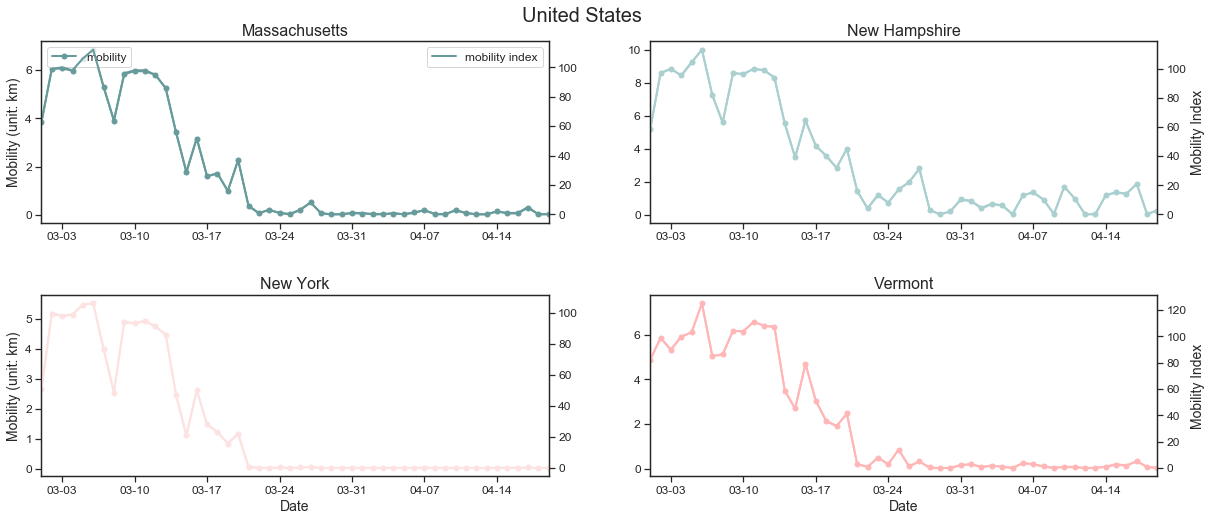

In [68]:
names_state_selected = ['Massachusetts', 'New Hampshire', 'New York', 'Vermont']
figure_mobility_all(data_m_state, names_state_selected, ncol = 2, fsize = (10, 4), ms = 5, fs = 16, logy = False, 
                    title = 'United States', country = 'US', pvi = False)

In [69]:
def figure_mobility_together(df, names_state, fsize = (5,3), ms = 2, fs = 10, logy = False, 
                    title = None, country = 'US', pvi = False):
    
    m = len(names_state)
    sns.set_style("ticks")
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    m = len(names_state)

    fig = plt.figure(figsize = fsize)
    ax = plt.subplot(111)

    for i, state in enumerate(names_state):

        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette[i]

        
        plot_df = df[df['state_name'] == state]
        ax.plot(plot_df['update_date'], plot_df['value'],
                linewidth = 2, marker = 'o', ms = ms, color = c, label = state) 
    
    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('Mobility (unit: km)', fontsize = fs - 2)
        
    fig.suptitle(title, fontsize = fs + 4, y = 0.94)
    
    ax.legend(loc='upper center', fancybox=True, ncol = 4, fontsize = fs - 4)
    
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    fig.savefig(_Figure_PATH_ + country + '_mobility.png', dpi = 400, bbox_inches='tight')
    

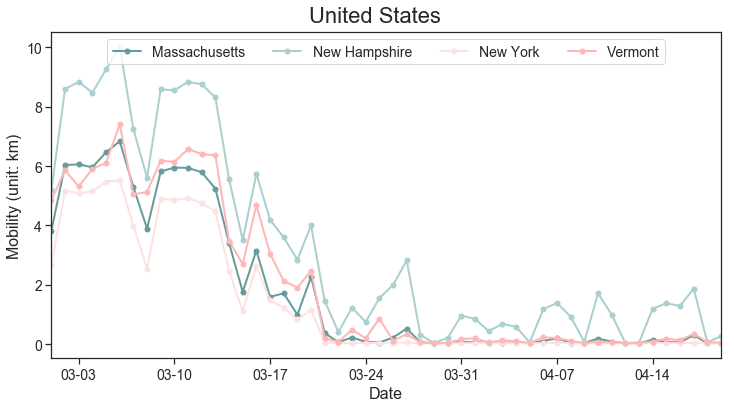

In [70]:
#names_state_selected = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']
figure_mobility_together(data_m_state, names_state_selected, fsize = (12, 6), ms = 5, fs = 18, logy = False, 
                    title = 'United States', country = 'US', pvi = False)

In [71]:
def figure_mobility_state_all(df, df_m, names_state, fsize = (5,3), ncol = 4, ms = 2, fs = 10, logy = False, 
                    title = None, country = 'US'):
    
    sns.set_style("ticks")
    palette = ['#AEDADE', '#F9F6D3', '#F5D1BE', '#EAA2A4', '#E385A9','#BA77B4']
    
    m = len(names_state)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    
    palette.reverse()
    
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, state in enumerate(names_state):
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df_m[df_m['state_name'] == state]
        
        data_single = df[(df['state_name'] == state) & (df['update_date'] == max(df['update_date']))]
        fips_selected = data_single.sort_values(by = 'cum_confirmed')['fips'].tail(6).tolist()                                                       
        fips_selected.reverse()
        for j, fips in enumerate(fips_selected):
            
            c = palette[j]
            plot_df_single = plot_df[plot_df['fips'] == fips]
            axes[ix].plot(plot_df_single['update_date'], plot_df_single['value'],
                    linewidth = 3, marker = 'o', ms = ms, color = c, label = plot_df_single['county_name'].tolist()[0]) # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Mobility (unit: km)', fontsize = fs - 2)
        
        handles, labels = axes[ix].get_legend_handles_labels()
        def flip(items, ncol):
            return itertools.chain(*[items[i::ncol] for i in range(ncol)])
        
        axes[ix].legend(flip(handles, 3), flip(labels, 3), loc='upper center', ncol = 3, fancybox=True, fontsize = fs - 4)
        
    
        axes[ix].set_title(state, fontsize = fs)
        axes[ix].set_xlim(min(df_m.update_date), max(df_m.update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.align_ylabels(axes[:, 0])
    fig.suptitle(title, fontsize = fs + 4, y = 0.94)

    fig.savefig(_Figure_PATH_ + country + '_county_mobility.png', dpi = 400, bbox_inches='tight')

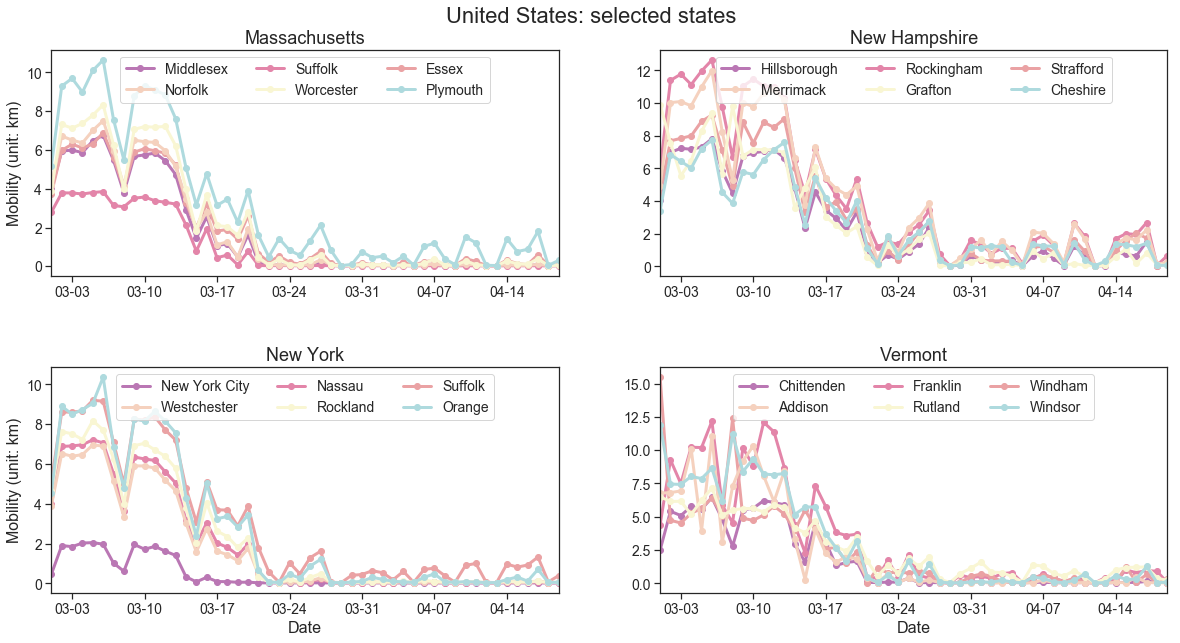

In [72]:
figure_mobility_state_all(data_county, data_m_county, names_state_selected, 
                          fsize = (10,5), ncol = 2, ms = 6, fs = 18, logy = False, 
                    title = 'United States: selected states', country = 'US')
                                                         
                                                         

In [73]:
data_m_nation = data_m_state.groupby(['update_date'])['ratio'].apply(lambda x : x.sum()).reset_index()

In [74]:
def figure_SP(df, df_SP, update_date_initial, fsize = (12,5), ms = 6, fs = 16, title = None, country = 'US'):
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    df = df[df['update_date'] >= update_date_initial]
    df_SP = df_SP[df_SP['update_date'] >= update_date_initial]
    df_SP = df_SP.reset_index(drop = True)
    df_nation = df.groupby(['update_date'])['ratio'].apply(lambda x : x.sum()).reset_index()
    fig = plt.figure(figsize = fsize)
    ax = plt.subplot(111)
    sns.set_style('ticks')
    ax.plot(df_nation['update_date'], df_nation['ratio'], 
            linewidth = 2, marker = 'o', ms = ms, color = palette[0], label = 'Mobility')
    
    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('Index', fontsize = fs - 2)
    
    ax.legend(loc = 'upper left', fontsize = fs - 2, bbox_to_anchor=(0.0, 1), fancybox=True)
    
    ax_twin = ax.twinx()
    ax_twin.plot(df_SP['update_date'], df_SP['close'], 
            linewidth = 2, marker = 'o', ms = ms, color = palette[3], label = 'S&P 500')
    
    ax_twin.set_ylabel('Index', fontsize = fs - 2)
    
    ax_twin.legend(loc = 'upper right', fontsize = fs - 2, bbox_to_anchor=(1, 1), fancybox=True)
    
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    fig.suptitle(title + ': ' + 'Correlation between Mobility and the S & P 500 index', fontsize = fs + 2, y = 0.95)
    
    fig.savefig(_Figure_PATH_ + country + '_mcorrelation.png', dpi = 400, bbox_inches='tight')

Data date range:  1927-12-30 to 2020-04-22
Number of rows in raw data:  23186


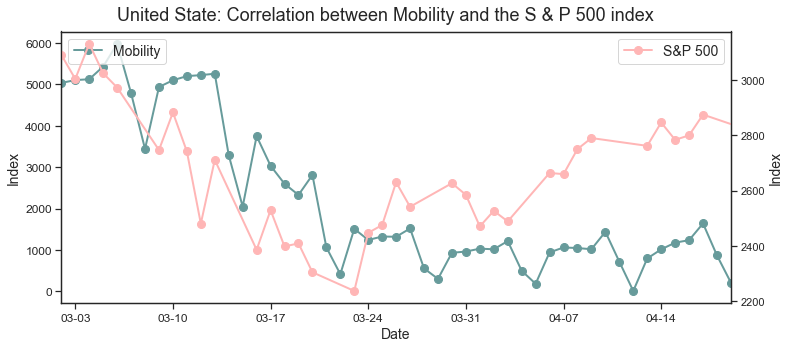

In [75]:
data_SP = load_SP_raw()
date_initial = datetime.date(int(2020),int(3),int(2))
figure_SP(data_m_state, data_SP, date_initial, fsize = (12,5), ms = 8, fs = 16, title = 'United State', country = 'US')

In [76]:
def figure_stock_list(df, stock_name_list, title_name_list, update_date_initial, 
                      fsize = (12,5), ncol = 2, ms = 6, fs = 16, title = None, country = 'US'):
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    df = df[df['update_date'] >= update_date_initial]
    
    df_nation = df.groupby(['update_date'])['ratio'].apply(lambda x : x.sum()).reset_index()
    
    m = len(stock_name_list)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, stock_name in enumerate(stock_name_list):
        
        ix = np.unravel_index(i, axes.shape)
        ax = axes[ix]
        ax.plot(df_nation['update_date'], df_nation['ratio'], 
                linewidth = 2, marker = 'o', ms = ms, color = palette[0], label = 'Mobility')
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            ax.set_xlabel('Date', fontsize = fs - 2)
        if i % ncol == 0:
            ax.set_ylabel('Index', fontsize = fs - 2)
        
        ax.set_title(title_name_list[i], fontsize = fs)
        
        ax.legend(loc = 'upper left', fontsize = fs - 2, bbox_to_anchor=(0.0, 1), fancybox=True)
    
        ax_twin = ax.twinx()
    
        data_stock = load_STOCK_raw(stock_name)
        data_stock = data_stock[data_stock['update_date'] >= update_date_initial]
        data_stock = data_stock.reset_index(drop = True)
        ax_twin.plot(data_stock['update_date'], data_stock['close'], 
                     linewidth = 2, marker = 'o', ms = ms, color = palette[i%3 + 1], label = stock_name_list[i])
        
        if i % ncol == ncol - 1:
            ax_twin.set_ylabel('Price', fontsize = fs - 2)
    
        ax_twin.legend(loc = 'upper right', fontsize = fs - 2, bbox_to_anchor=(1, 1), fancybox=True)
    
        ax.set_xlim(min(df.update_date), max(df.update_date))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    fig.suptitle(title + ': ' + 'correlation between mobility and the stock market', fontsize = fs + 2, y = 0.9)
    
    fig.savefig(_Figure_PATH_ + country + '_mcorrelation_sm.png', dpi = 400, bbox_inches='tight')

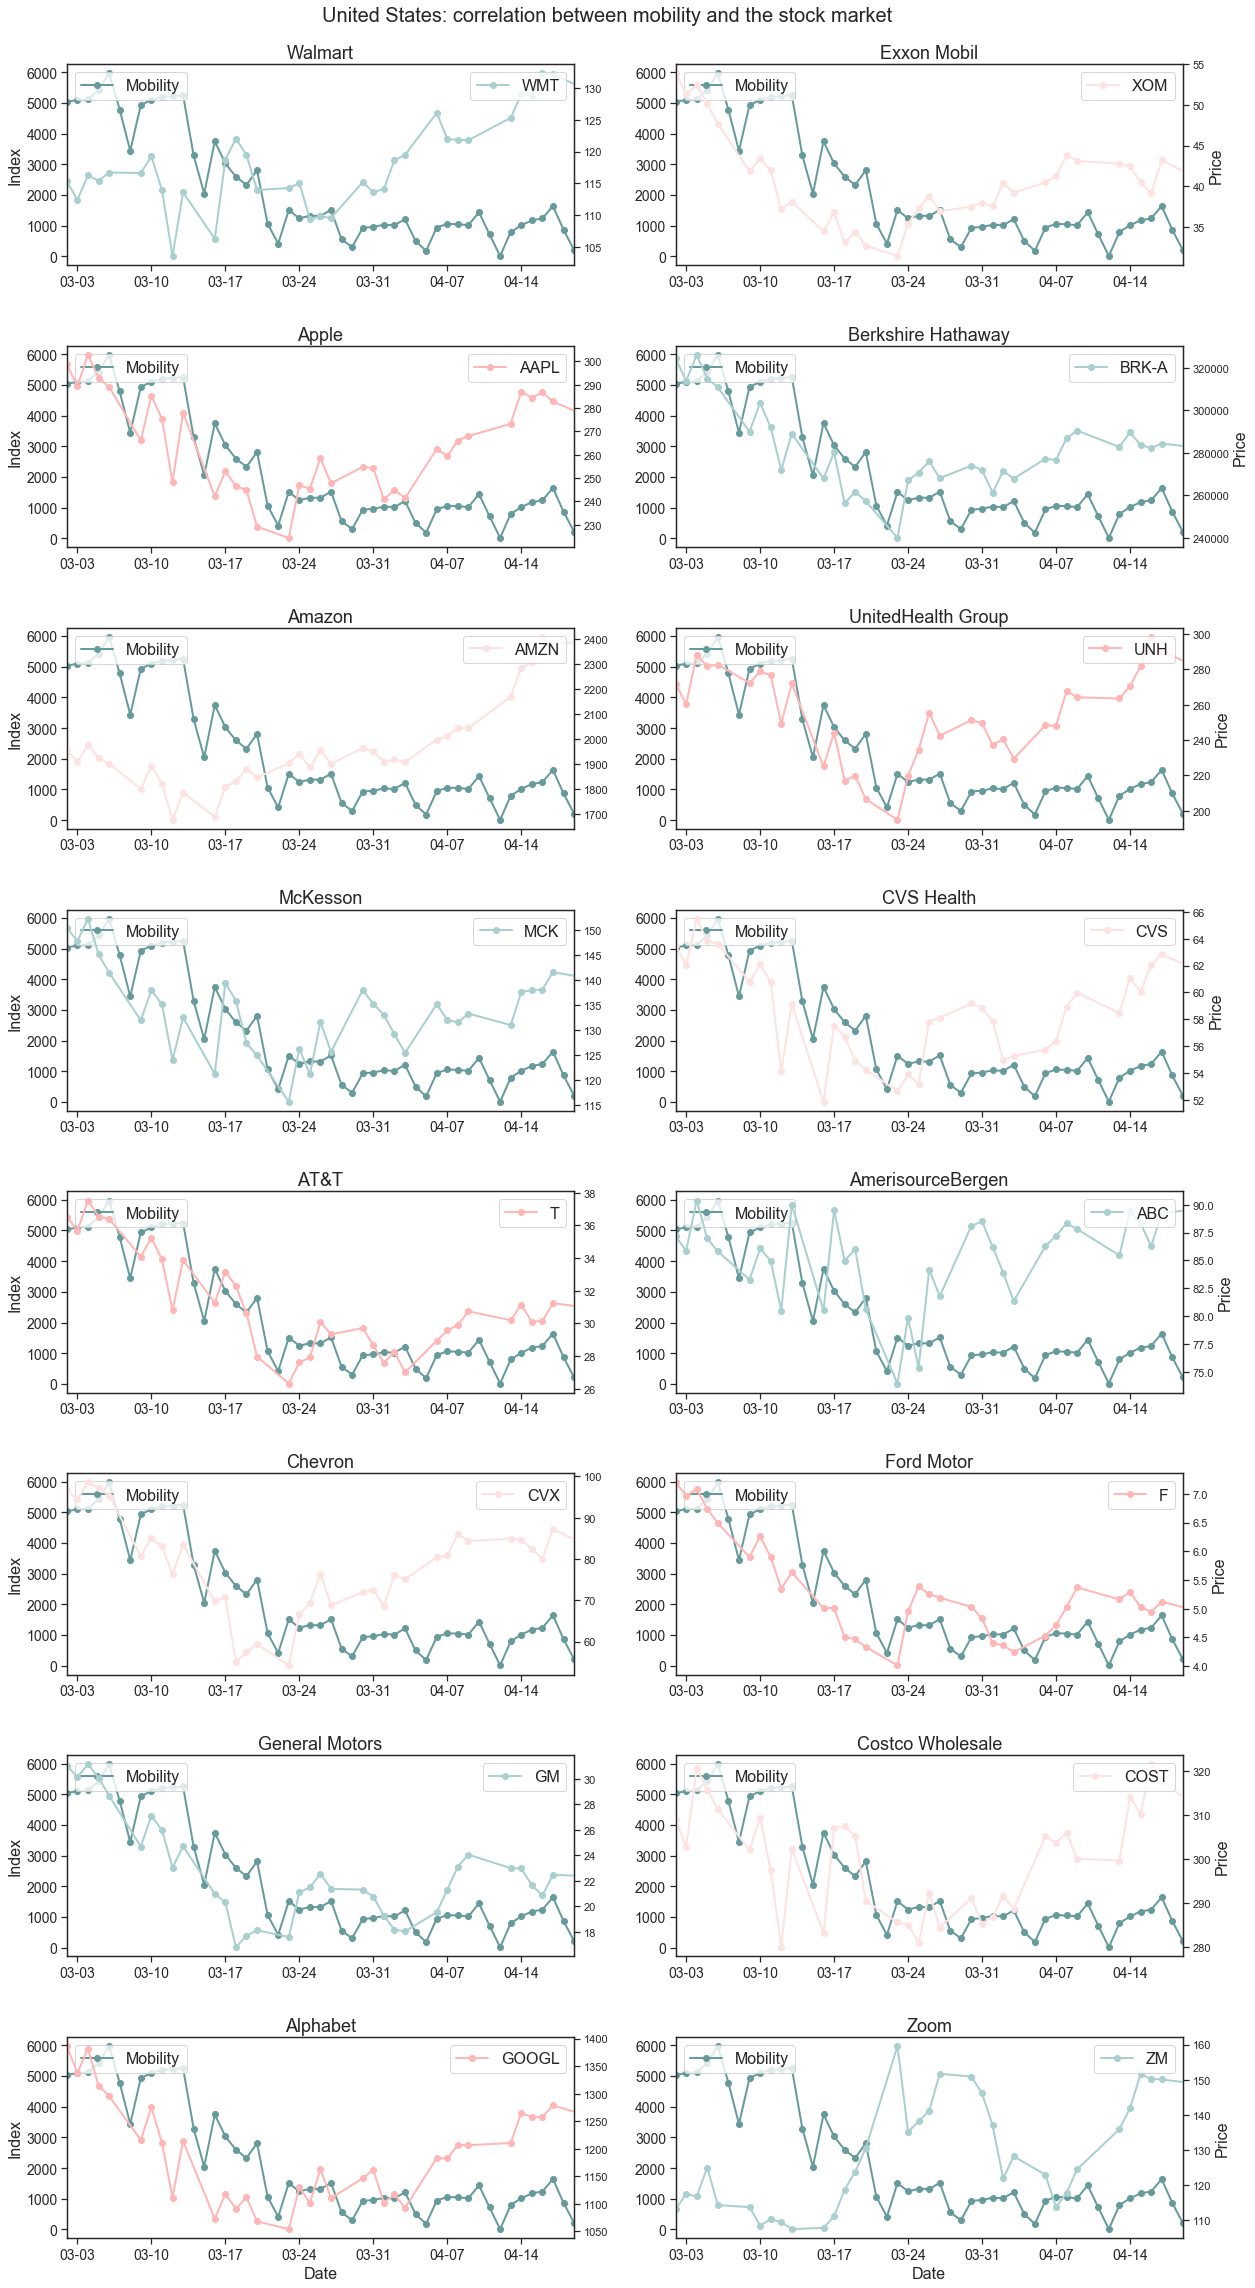

In [77]:
stock_name_list = ['WMT', 'XOM', 'AAPL', 'BRK-A', 'AMZN', 'UNH', 'MCK', 'CVS',
                  'T', 'ABC', 'CVX', 'F', 'GM', 'COST', 'GOOGL', 'ZM']
title_name_list = ['Walmart', 'Exxon Mobil', 'Apple', 'Berkshire Hathaway',
                   'Amazon', 'UnitedHealth Group', 'McKesson', 'CVS Health',
                   'AT&T', 'AmerisourceBergen', 'Chevron', 'Ford Motor', 
                   'General Motors', 'Costco Wholesale', 'Alphabet', 'Zoom']
date_initial = datetime.date(int(2020),int(3),int(2))
figure_stock_list(data_m_state, stock_name_list, title_name_list, 
                  date_initial, fsize = (10,5), ncol = 2, ms = 6, fs = 18,
                  title = 'United States', country = 'US')